In [3]:
import pandas as pd
import numpy as np
import ser
import lib_tree
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score1
import time
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
import numpy as np
from sklearn.tree import _tree

def get_rules(dt, feature_names, class_names=None):
    tree_ = dt.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            # Store path and the outcome probability for each class at leaf
            path += [(tree_.value[node][0], tree_.n_node_samples[node])]
            paths.append(path)

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    sorted_indices = np.argsort(samples_count)[::-1]  # sort descending
    paths = [paths[i] for i in sorted_indices]

    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += p
        rule += " then "
        # handle both classification and regression trees
        if class_names:
            classes = path[-1][0]
            class_index = np.argmax(classes)
            rule += f"class: {class_names[class_index]} (proba: {np.round(100.0 * classes[class_index] / np.sum(classes), 2)}%)"
        else:
            rule += f"value: {np.round(path[-1][0][0], 3)}"
        rule += f" | based on {path[-1][1]:,} samples"
        rules.append(rule)

    return rules




In [4]:
Final_Data_S1= pd.read_csv("final_H358.csv")
Final_Data_S1.loc[Final_Data_S1[Final_Data_S1.labels.isin([ 2.0, 3.0,4.0])].index, 'labels']=1.0
ys = Final_Data_S1.labels
Xs= Final_Data_S1.drop(['Time', 'labels'], axis=1)

In [77]:
train= pd.read_csv("train_data.csv")
test= pd.read_csv("test_data.csv")
train.loc[train[train.labels.isin([ 2.0])].index, 'labels']=1.0
test.loc[test[test.labels.isin([ 2.0])].index, 'labels']=1.0
yt = train.labels
Xt= train.drop([ 'labels'], axis=1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xt, yt, test_size=0.9, stratify=yt,  random_state = 42)
X_train_t = X_train_t.to_numpy()
y_train_t= y_train_t.to_numpy()
y_test_t = test.labels
X_test_t = test.drop([ 'labels'], axis=1)

Base Model (Train only on source, test on target)

In [47]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(Xs, ys)
y_pred =  clf.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
roc = roc_auc_score(y_test_t, y_pred)
print("accuracy:",accuracy_score(y_test_t, y_pred))
print('Weighted F1 score: ', f1_weighted)
print('ROC AUC score:', roc)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix no TL:")
print(cm)

accuracy: 0.7865168539325843
Weighted F1 score:  0.8331806198971103
ROC AUC score: 0.6231970312281193
precision: [0.77642276 0.9047619 ]
recall; [0.98963731 0.25675676]
fscore: [0.87015945 0.4       ]
support: [193  74]
Confusion Matrix no TL:
[[191   2]
 [ 55  19]]


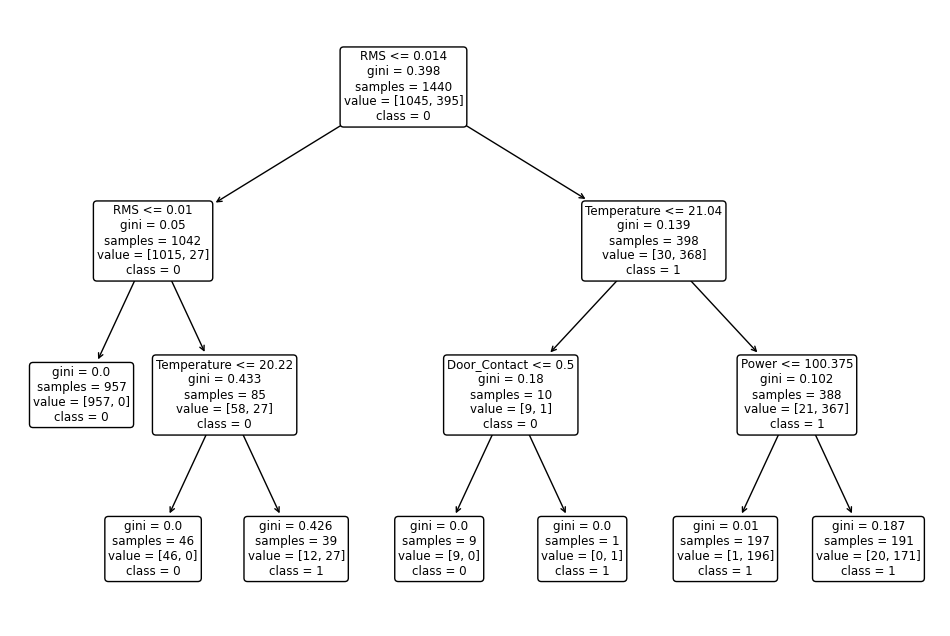

In [48]:
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1'], rounded=True)
plt.show()

In [124]:
rules = get_rules(clf, ['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact','Window_Contact'],['0','1'])
for rule in rules:
    print(rule)

if (RMS <= 0.014) and (RMS <= 0.01) then class: 0 (proba: 100.0%) | based on 957 samples
if (RMS > 0.014) and (Temperature > 21.04) then class: 1 (proba: 94.59%) | based on 388 samples
if (RMS <= 0.014) and (RMS > 0.01) then class: 0 (proba: 68.24%) | based on 85 samples
if (RMS > 0.014) and (Temperature <= 21.04) then class: 0 (proba: 90.0%) | based on 10 samples


Base Model (Train only on target, test on target)

In [84]:
model = DecisionTreeClassifier(max_depth=3)
model = model.fit(X_train_t, y_train_t)
y_pred =  model.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
f1_weighted = f1_score(y_pred, y_test_t, average='weighted')
roc = roc_auc_score(y_test_t, y_pred)
print("accuracy:",accuracy_score(y_test_t, y_pred))
print('ROC AUC score:', roc)
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix no TL:")
print(cm)

accuracy: 0.898876404494382
ROC AUC score: 0.842564066657331
Weighted F1 score:  0.9026875238194959
precision: [0.89903846 0.89830508]
recall; [0.96891192 0.71621622]
fscore: [0.93266833 0.79699248]
support: [193  74]
Confusion Matrix no TL:
[[187   6]
 [ 21  53]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


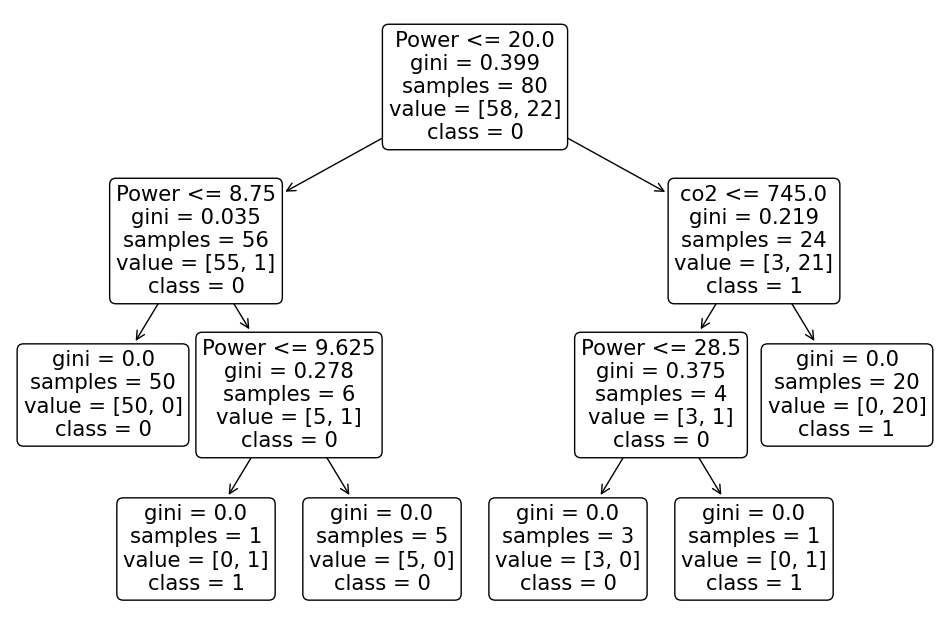

In [125]:
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1'], rounded=True)
plt.show()

In [126]:
rules = get_rules(model, ['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact','Window_Contact'],['0','1'])
for rule in rules:
    print(rule)

if (Power <= 20.0) and (Power <= 8.75) then class: 0 (proba: 100.0%) | based on 50 samples
if (Power > 20.0) and (co2 > 745.0) then class: 1 (proba: 100.0%) | based on 20 samples
if (Power <= 20.0) and (Power > 8.75) and (Power > 9.625) then class: 0 (proba: 100.0%) | based on 5 samples
if (Power > 20.0) and (co2 <= 745.0) and (Power <= 28.5) then class: 0 (proba: 100.0%) | based on 3 samples
if (Power > 20.0) and (co2 <= 745.0) and (Power > 28.5) then class: 1 (proba: 100.0%) | based on 1 samples
if (Power <= 20.0) and (Power > 8.75) and (Power <= 9.625) then class: 1 (proba: 100.0%) | based on 1 samples


SER original

In [99]:
clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(Xs, ys)
SER = copy.deepcopy(clf)
ser.SER(0,SER, X_train_t, y_train_t, original_ser=True)
print('ser original accuracy:', SER.score(X_test_t, y_test_t))
y_pred = SER.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
roc = roc_auc_score(y_test_t, y_pred)
f1_weighted = f1_score(y_test_t,y_pred, average='weighted')
print('Weighted F1 score: ', f1_weighted)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('roc auc:', roc)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix ser original:")
print(cm)

ser original accuracy: 0.8913857677902621
Weighted F1 score:  0.8859347865125526
precision: [0.88679245 0.90909091]
recall; [0.97409326 0.67567568]
fscore: [0.92839506 0.7751938 ]
roc auc: 0.8248844699621901
support: [193  74]
Confusion Matrix ser original:
[[188   5]
 [ 24  50]]


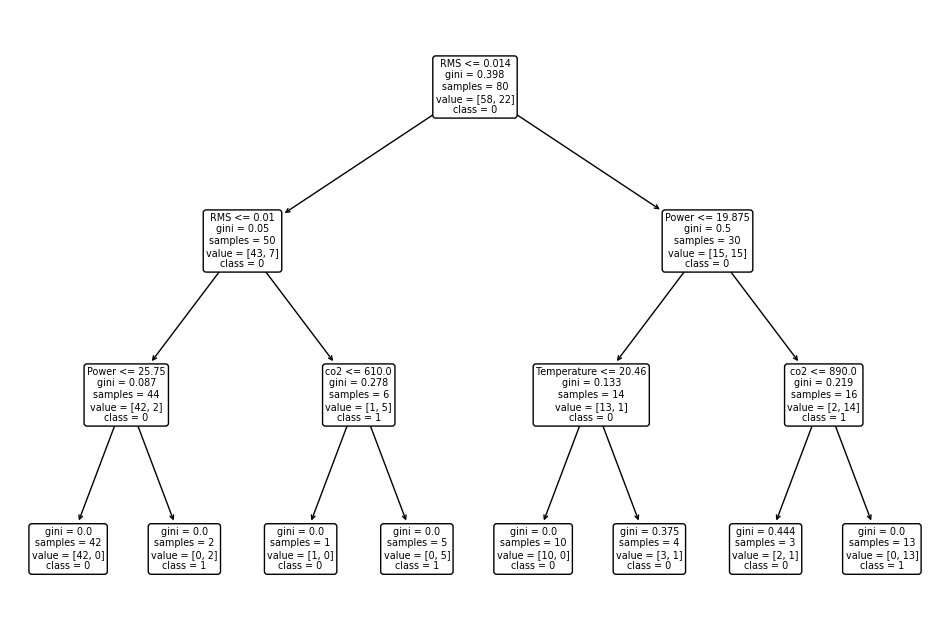

In [100]:
plt.figure(figsize=(12, 8))
plot_tree(SER, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1'], rounded=True)
plt.show()

In [127]:
rules = get_rules(SER, ['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact','Window_Contact'],['0','1'])
for rule in rules:
    print(rule)

if (RMS <= 0.014) and (RMS <= 0.01) and (Power <= 25.75) then class: 0 (proba: 100.0%) | based on 42 samples
if (RMS > 0.014) and (Power > 19.875) and (co2 > 890.0) then class: 1 (proba: 100.0%) | based on 13 samples
if (RMS > 0.014) and (Power <= 19.875) and (Temperature <= 20.46) then class: 0 (proba: 100.0%) | based on 10 samples
if (RMS <= 0.014) and (RMS > 0.01) and (co2 > 610.0) then class: 1 (proba: 100.0%) | based on 5 samples
if (RMS > 0.014) and (Power <= 19.875) and (Temperature > 20.46) then class: 0 (proba: 75.0%) | based on 4 samples
if (RMS > 0.014) and (Power > 19.875) and (co2 <= 890.0) then class: 0 (proba: 66.67%) | based on 3 samples
if (RMS <= 0.014) and (RMS <= 0.01) and (Power > 25.75) then class: 1 (proba: 100.0%) | based on 2 samples
if (RMS <= 0.014) and (RMS > 0.01) and (co2 <= 610.0) then class: 0 (proba: 100.0%) | based on 1 samples


SER IMB

In [108]:
target_names = ['class 0', 'class 1']
cl_no_red = [1]
Nkmin = sum(y_train_t == cl_no_red)
root_source_values = lib_tree.get_node_distribution(clf, 0).reshape(-1)
props_s = root_source_values
props_s = props_s / sum(props_s)
props_t = np.zeros(props_s.size)
for k in range(props_s.size):
    props_t[k] = np.sum(y_train_t == k) / y_train_t.size
coeffs = np.divide(props_t, props_s)

In [112]:
ser_imb = copy.deepcopy(clf)
ser.SER(0, ser_imb, X_train_t, y_train_t, original_ser=False, no_red_on_cl=True, cl_no_red=cl_no_red, no_ext_on_cl=True, cl_no_ext=cl_no_red, ext_cond=True, leaf_loss_quantify=True, leaf_loss_threshold=0.2, coeffs=coeffs, root_source_values=root_source_values, Nkmin=Nkmin)
print('ser* accuracy:', ser_imb.score(X_test_t, y_test_t))
y_pred = ser_imb.predict(X_test_t)
precision, recall, fscore, support = score1(y_test_t, y_pred)
roc_auc = roc_auc_score (y_test_t, y_pred)
f1_weighted = f1_score(y_test_t,y_pred, average='weighted')
print('Weighted F1 score: ', f1_weighted)
print('ROC AUC :', roc_auc)
print('precision:', precision)
print('recall;', recall)
print('fscore:', fscore)
print('support:', support)
cm = confusion_matrix(y_test_t, y_pred)
print("Confusion Matrix:")
print(cm)
print('\n')
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("accuracy per class", accuracy_per_class)
macro_precision = precision_score(y_test_t, y_pred, average='macro')
micro_precision = precision_score(y_test_t, y_pred, average='micro')

# Calculate weighted average precision
weighted_precision = precision_score(y_test_t, y_pred, average='weighted')
print('macro precision:', macro_precision )

print('micro precision:', micro_precision )

print('weighted_precision:', weighted_precision )

print(classification_report(y_test_t, y_pred, target_names=target_names))

ser* accuracy: 0.8838951310861424
Weighted F1 score:  0.877291244096517
ROC AUC : 0.8113709564486767
precision: [0.87850467 0.90566038]
recall; [0.97409326 0.64864865]
fscore: [0.92383292 0.75590551]
support: [193  74]
Confusion Matrix:
[[188   5]
 [ 26  48]]


accuracy per class [0.97409326 0.64864865]
macro precision: 0.8920825251278435
micro precision: 0.8838951310861424
weighted_precision: 0.8860309730100643
              precision    recall  f1-score   support

     class 0       0.88      0.97      0.92       193
     class 1       0.91      0.65      0.76        74

    accuracy                           0.88       267
   macro avg       0.89      0.81      0.84       267
weighted avg       0.89      0.88      0.88       267



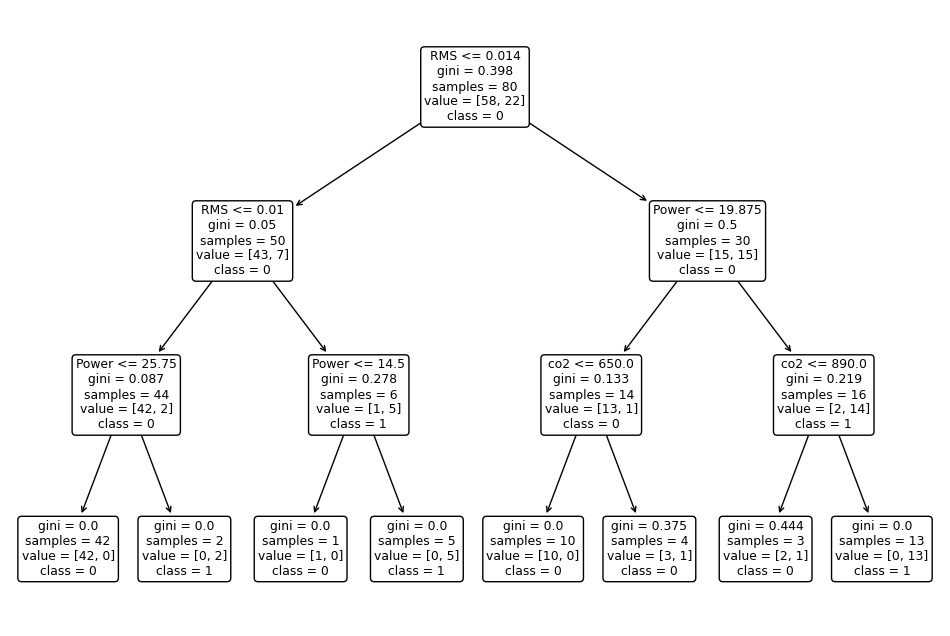

In [114]:
plt.figure(figsize=(12, 8))
plot_tree(ser_imb, feature_names=['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact', 'Window_Contact'], class_names=['0','1'], rounded=True)
plt.show()

In [128]:
rules = get_rules(ser_imb, ['co2', 'Motion', 'RMS', 'Power', 'Temperature', 'Door_Contact','Window_Contact'],['0','1'])
for rule in rules:
    print(rule)

if (RMS <= 0.014) and (RMS <= 0.01) and (Power <= 25.75) then class: 0 (proba: 100.0%) | based on 42 samples
if (RMS > 0.014) and (Power > 19.875) and (co2 > 890.0) then class: 1 (proba: 100.0%) | based on 13 samples
if (RMS > 0.014) and (Power <= 19.875) and (co2 <= 650.0) then class: 0 (proba: 100.0%) | based on 10 samples
if (RMS <= 0.014) and (RMS > 0.01) and (Power > 14.5) then class: 1 (proba: 100.0%) | based on 5 samples
if (RMS > 0.014) and (Power <= 19.875) and (co2 > 650.0) then class: 0 (proba: 75.0%) | based on 4 samples
if (RMS > 0.014) and (Power > 19.875) and (co2 <= 890.0) then class: 0 (proba: 66.67%) | based on 3 samples
if (RMS <= 0.014) and (RMS <= 0.01) and (Power > 25.75) then class: 1 (proba: 100.0%) | based on 2 samples
if (RMS <= 0.014) and (RMS > 0.01) and (Power <= 14.5) then class: 0 (proba: 100.0%) | based on 1 samples
